# Framework

- Data - Palbociclib Data (Proteomics and GDSC2)
- Preprocessing method - missing data imputation by lower quantile (0 to 0.25)
- Feature selection (Filtering) - select features with pearson correlation >= |0.4|
- Model - Elastic Net
- Target variable used - AUC

In [1]:
import os 
import DataFunctions as utils
import Visualisation as vis
from toolkit import * 
import numpy as np
import pandas as pd

c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


In [3]:
### Config Parameters

## Data 

save_results_path = 'data//results//workbook-5-jun' 

if not os.path.exists(save_results_path):
    os.makedirs(save_results_path)

# create the full dataset
drug_selected = 'Palbociclib'

## Preprocessing Method
# Between fill by zero, impute by random variable between 0 to 1st quantile
# Impute1stQuantile, Fill0, ImputeKNN
preprocessing_method = 'Impute1stQuantile'

# set threshold for feature removal (0.8 means remove features with > 80% missing values)
feature_nan_removal_threshold = 0.8

## Feature Selection Methods

## Models 
## Target variable used
target_variable = 'AUC'

# hyperparameters
max_gene_target_disance = 2 # specify the level of biological relevance to drug target(s)
statistical_filter_size = 100 # can be optimized using global feature dropout testing
monte_carlo_cross_validation_size = 5 # can be automatically optimized via rank impact assessment
models_used = ['ElasticNet']
models_hyperparameters = [{'alpha': 0.005},]

# extra hyperparameters
statistical_filter_threshold = 0.05 # currently not in use
n_cores_to_use = 1 # global parameter for parallel processing

In [4]:
data_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

In [5]:
# Baseline Predictivity of the Full Dataset and using the most correlated feature to the target

# get the most correlated feature to the target
most_correlated_feature = feature_data.corrwith(label_data).sort_values(ascending=False).index[0]
correlated_value = feature_data.corrwith(label_data).sort_values(ascending=False)[0]


print(f'The most correlated feature to the target is: {most_correlated_feature}, with value: {correlated_value}')

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


The most correlated feature to the target is: O95292;VAPB_HUMAN, with value: 0.4255021912734304


In [6]:


feature_size_tested = []
for i in range(1, 50, 10):
    feature_size_tested.append(i)

all_df = pd.DataFrame()
rng_list = np.random.randint(0, 100000, 5)

for feature_size in feature_size_tested:
    print(f'------------------ feature size: {feature_size}')
    tool = Toolkit(feature_data=feature_data, label_data=label_data)

    tool.add_condition('network_stat',
                    True,
                    impute_with_network_stat_selection,
                    (nth_degree_neighbours, 2, feature_size))

    tool.add_model('ElasticNet',
                'ElasticNet', 
                {'alpha': 0.005})
    tool.set_rng_list(rng_list)

    feature_size_df = tool.run_all(n_jobs=2, verbose=True)
    # create a column for feature size for each row
    feature_size_df['feature_size'] = feature_size
    all_df = pd.concat([all_df, feature_size_df], axis=0)

------------------ feature size: 1
### All models ran
------------------ feature size: 11
### All models ran
------------------ feature size: 21
### All models ran
------------------ feature size: 31
### All models ran
------------------ feature size: 41
### All models ran


In [7]:
all_df.shape

(25, 14)

In [8]:
all_df.reset_index(drop=True, inplace=True)

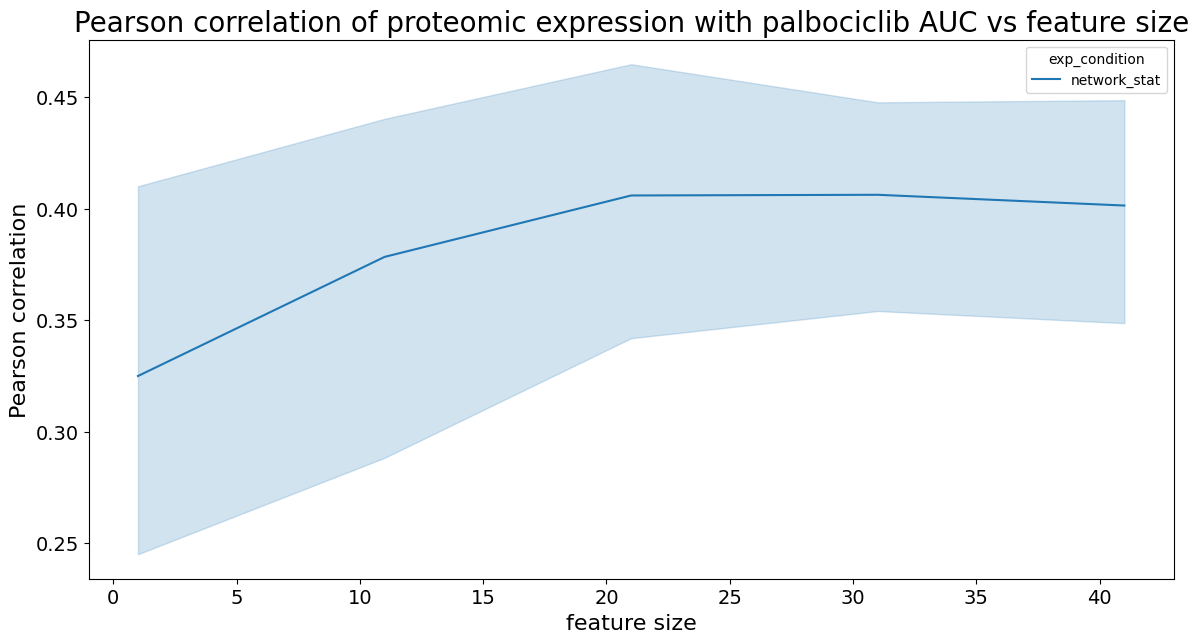

In [9]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='corr', hue='exp_condition', data=all_df, ax=ax)
ax.set_title(f'Pearson correlation of proteomic expression with palbociclib AUC vs feature size')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.savefig(save_results_path+'feature_size_pearson_corr.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
### Record SHAP values for network stat features

tool = Toolkit(feature_data=feature_data, label_data=label_data)

tool.add_condition('network_stat',
                True,
                impute_with_network_stat_selection,
                (nth_degree_neighbours, 2, 100))

tool.add_model('ElasticNet',
            'ElasticNet', 
            {'alpha': 0.005})
tool.set_rng_list(rng_list)

shap_df = tool.run_all(n_jobs=2, verbose=True)

shap_contribs = get_mean_contribution(shap_df, 'network_stat')



### All models ran


In [12]:
shap_df.shape

(5, 13)

In [13]:
shap_contribs.shape

(100,)

### Plotting mean contribution


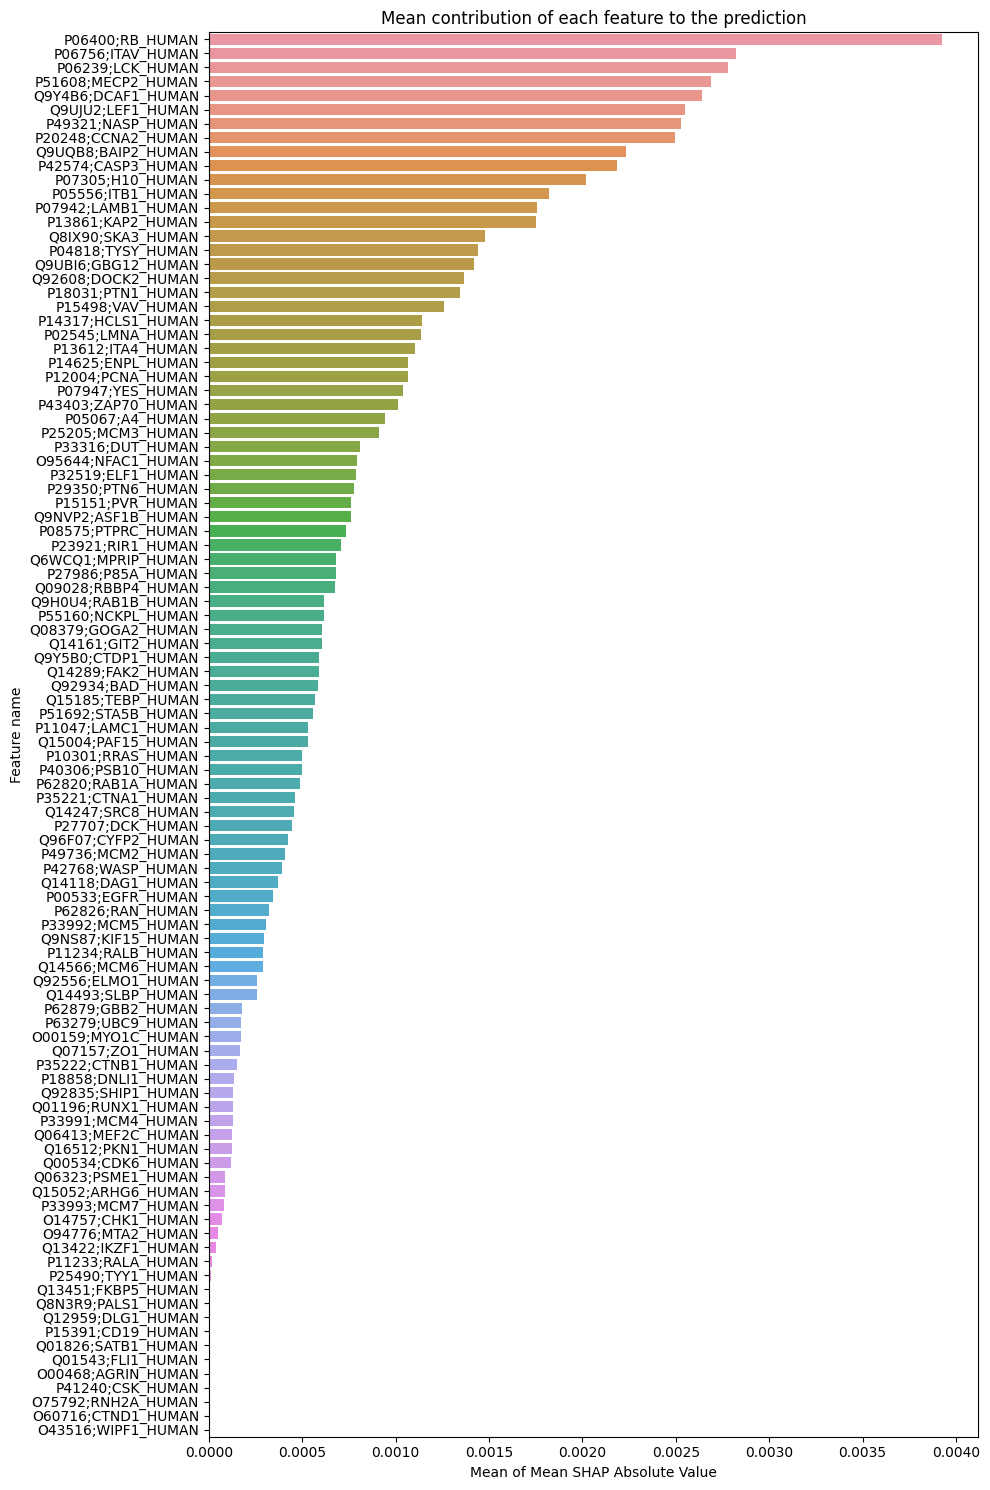

In [14]:
# plot the mean shap values

import matplotlib.pyplot as plt
import seaborn as sns

print('### Plotting mean contribution')
plt.figure(figsize=(10, 15))
sns.barplot(x=shap_contribs.values, y=shap_contribs.index)
plt.title('Mean contribution of each feature to the prediction')
plt.xlabel('Mean of Mean SHAP Absolute Value')
plt.ylabel('Feature name')
plt.tight_layout()
plt.savefig(save_results_path+'mean_contribution.png', dpi=300)
plt.show()

In [21]:
## Elimination Algorithm 

def greedy_backward_feature_elimination(toolkit: Toolkit, initial_contrib: pd.Series, final_size: int, n_jobs=1, verbose=False):

    features_rank = []

    current_size = initial_contrib.shape[0]
    current_contrib = initial_contrib.copy()
    if verbose: 
        print(f'--- Beginning backward elimination, initial size: {current_size}')
    while current_size > final_size: 
        # sort the initial contribution in descending order
        current_contrib.sort_values(ascending=False, inplace=True)
        # select the index of the feature with highest contribution
        feature_to_remove = current_contrib.index[0]
        # create a list of features as copy of initial contribution
        feature_list = current_contrib.copy().index 
        # remove the feature with highest contribution
        feature_list = feature_list.drop(feature_to_remove)

        current_size = feature_list.shape[0]
        condition = f'feature_size_{current_size}'
        toolkit.add_condition(condition, True, impute_with_preset_features, (feature_list,))
        current_df = toolkit.run_selected_condition(condition, n_jobs=n_jobs, verbose=False)
        current_contrib = get_mean_contribution(current_df, condition)
        current_mean_corr = current_df['corr'].mean()

        if verbose:
            print(f'--- Feature size: {current_size}, feature removed: {feature_to_remove}, mean corr: {current_mean_corr}')


        features_rank.append({'feature_removed': feature_to_remove, 'mean_corr': current_mean_corr, 'feature_size': current_size})

    return pd.DataFrame(features_rank)

feature_ranks_df = greedy_backward_feature_elimination(tool, shap_contribs, 80, n_jobs=2, verbose=True)

    


--- Beginning backward elimination, initial size: 100
--- Feature size: 99, feature removed: P06400;RB_HUMAN, mean corr: 0.42352273782896593
--- Feature size: 98, feature removed: P32519;ELF1_HUMAN, mean corr: 0.4083808896343192
--- Feature size: 97, feature removed: P18031;PTN1_HUMAN, mean corr: 0.4061260399910676
--- Feature size: 96, feature removed: P06756;ITAV_HUMAN, mean corr: 0.40329865818204247
--- Feature size: 95, feature removed: P05556;ITB1_HUMAN, mean corr: 0.39158754771008136
--- Feature size: 94, feature removed: P13861;KAP2_HUMAN, mean corr: 0.3838120632773173
--- Feature size: 93, feature removed: Q9UJU2;LEF1_HUMAN, mean corr: 0.3919618246313981
--- Feature size: 92, feature removed: Q9UQB8;BAIP2_HUMAN, mean corr: 0.3929332362508276
--- Feature size: 91, feature removed: P08575;PTPRC_HUMAN, mean corr: 0.3877356782578555
--- Feature size: 90, feature removed: P43403;ZAP70_HUMAN, mean corr: 0.38948455253648223
--- Feature size: 89, feature removed: Q14247;SRC8_HUMAN, mea

In [22]:
feature_ranks_df.head()

,feature_removed,mean_corr,feature_size
0,P06400;RB_HUMAN,0.423523,99
1,P32519;ELF1_HUMAN,0.408381,98
2,P18031;PTN1_HUMAN,0.406126,97
3,P06756;ITAV_HUMAN,0.403299,96
4,P05556;ITB1_HUMAN,0.391588,95


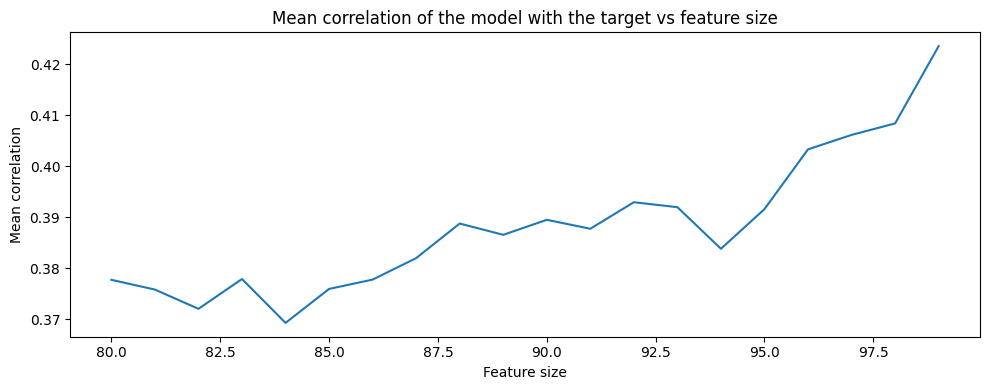

In [24]:
# quick plot the mean corr

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

sns.lineplot(x='feature_size', y='mean_corr', data=feature_ranks_df)
plt.title('Mean correlation of the model with the target vs feature size')
plt.xlabel('Feature size')
plt.ylabel('Mean correlation')
plt.tight_layout()

# plt.savefig(save_results_path+'mean_corr_vs_feature_size.png', dpi=300)
plt.show()
